# Import

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# Read data and pre-process

In [3]:
def select_features(df, top_n=2000):
    var = df.var(axis=1)
    top = var.sort_values(ascending=False).head(top_n).index
    return df.loc[top]

# Đọc file multi-omics (đổi tên file phù hợp)
mrna = pd.read_csv("data/TCGA-LUAD.star_fpkm.tsv/TCGA-LUAD.star_fpkm.tsv", sep='\t', index_col=0).fillna(0)
mirna = pd.read_csv("data/TCGA-LUAD.mirna.tsv/TCGA-LUAD.mirna.tsv", sep='\t', index_col=0).fillna(0)
cnv = pd.read_csv("data/TCGA-LUAD.gene-level_absolute.tsv/TCGA-LUAD.gene-level_absolute.tsv", sep='\t', index_col=0).fillna(0)
meth = pd.read_csv("data/TCGA-LUAD.methylation450.tsv/TCGA-LUAD.methylation450.tsv", sep='\t', index_col=0).fillna(0)

# Lấy giao các sample chung
sample_common = list(set(mrna.columns) & set(mirna.columns) & set(cnv.columns) & set(meth.columns))
# print("sample common\n", sample_common)
mrna = select_features(mrna[sample_common], 2000)
# print("mrna\n", mrna)
mirna = select_features(mirna[sample_common], 200)
cnv = select_features(cnv[sample_common], 500)
meth = select_features(meth[sample_common], 2000)

def scale_omics(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df.T), index=df.columns, columns=df.index)

mrna_scaled = scale_omics(mrna)
mirna_scaled = scale_omics(mirna)
cnv_scaled = scale_omics(cnv)
meth_scaled = scale_omics(meth)

df_all = pd.concat([mrna_scaled, mirna_scaled, cnv_scaled, meth_scaled], axis=1)
print(f"Shape input: {df_all.shape}")

# Đầu vào autoencoder (samples x features)
X = df_all.values.astype(np.float32)
print(X)

Shape input: (442, 4700)
[[-0.4745514  -0.24952815  1.058772   ...  1.2299637   0.6417705
   0.36737564]
 [-1.0842063   0.26582998  1.1539686  ... -0.9929283   0.79123837
   0.9660687 ]
 [ 0.9087978  -0.8294557  -1.2768953  ...  1.1979718  -1.4610444
  -1.2851408 ]
 ...
 [ 0.4273847  -0.57757664  0.235284   ... -0.9929283   0.6716648
  -1.2851408 ]
 [ 0.5634192  -0.9111736  -1.2710348  ... -0.9929283  -1.4610444
   0.9938041 ]
 [-0.5013145  -0.69254905 -1.3210306  ... -0.9929283   0.5849105
   0.99664587]]


In [4]:
print([df.isna().sum().sum() for df in [mrna, mirna, cnv, meth]])
# print(mrna)

[np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


# Define autoencoder model

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=100):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# Initialize model, optimizer, loss

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X.shape[1]
model = Autoencoder(input_dim).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=5e-4)
loss_fn = nn.MSELoss()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4700, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=4700, bias=True)
  )
)


# Train

Epoch 20, loss = 3.8470
Epoch 40, loss = 1.0201
Epoch 60, loss = 0.4475
Epoch 80, loss = 0.1526
Epoch 100, loss = 0.1620
Epoch 120, loss = 0.1903
Epoch 140, loss = 0.1878
Epoch 160, loss = 0.1361
Epoch 180, loss = 0.1344
Epoch 200, loss = 0.2131


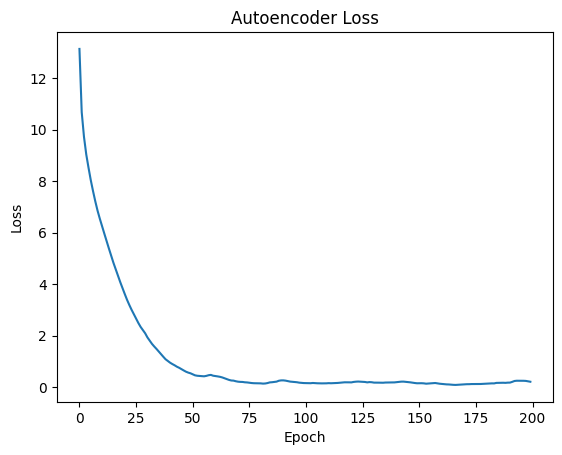

In [7]:
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
n_epochs = 200
batch_size = 32

losses = []
for epoch in range(n_epochs):
    perm = torch.randperm(X_tensor.size(0)) # Returns a random permutation of integers from 0 to n - 1 (in tensor)
    epoch_loss = 0
    for i in range(0, X_tensor.size(0), batch_size):
        idx = perm[i:i + batch_size]
        batch = X_tensor[idx]
        optimizer.zero_grad()
        output = model(batch)
        loss = loss_fn(output, batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, loss = {epoch_loss:.4f}")

plt.plot(losses)
plt.title("Autoencoder Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Export latent embedding for downstream clustering

In [9]:
model.eval()
with torch.no_grad():
    latent_emb = model.encoder(X_tensor).cpu().numpy()  # shape (num_samples, latent_dim)

pd.DataFrame(latent_emb, index=df_all.index).to_csv("luad_omics_latent.csv")
print("Đã lưu file latent embedding shape:", latent_emb.shape)

Đã lưu file latent embedding shape: (442, 100)
